In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm


In [30]:
import sys
import os

# Obtenir le chemin absolu du répertoire courant du notebook
notebook_dir = os.getcwd()
print(notebook_dir)

# Ajouter le répertoire parent au PYTHONPATH
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

# Définir le chemin vers les données
DATA_PATH = os.path.join(parent_dir, "datasets", "raw", "ab_data.csv")
print(f"Chemin des données : {DATA_PATH}")

c:\Users\ouryb\ab-testing-project\notebooks
Chemin des données : c:\Users\ouryb\ab-testing-project\datasets\raw\ab_data.csv


In [23]:
from src.data.data_processor import (
    load_data,
    clean_data,
    prepare_features
)
from src.analysis.ab_test_analyzer import (
    calculate_conversion_rates,
    perform_statistical_test
)
from src.visualization.streamlit_plots import (
    plot_conversion_rates,
    plot_conversion_by_hour,
    plot_conversion_by_day
)
from src.models.logistic_regression import (
    fit_logistic_regression,
    get_model_summary
)


In [31]:
df = load_data(DATA_PATH)

2025-05-22 20:56:11,951 - src.data.data_processor - INFO - Chargement des données depuis c:\Users\ouryb\ab-testing-project\datasets\raw\ab_data.csv
2025-05-22 20:56:12,147 - src.data.data_processor - INFO - Données chargées avec succès : 294478 lignes


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [25]:
df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape


(1928, 5)

In [26]:
df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].shape

(1965, 5)

In [27]:
df = df.drop(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index)
df = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index)

In [28]:
duplicate_users = df[df.duplicated('user_id', keep=False)]
duplicate_users

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [29]:
df = df[~df['user_id'].isin(duplicate_users['user_id'])]

In [45]:
df.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0
hour,0
day_of_week,0
intercept,0
ab_group,0
day_Monday,0


In [30]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

n_control = control.shape[0]
n_treatment = treatment.shape[0]

In [31]:
n_treatment

145309

In [32]:
n_control

145274

In [33]:
p_control = control['converted'].mean()
p_treatment = treatment['converted'].mean()

print("n_control * p_control =", n_control * p_control)
print("n_control * (1 - p_control) =", n_control * (1 - p_control))
print("n_treatment * p_treatment =", n_treatment * p_treatment)
print("n_treatment * (1 - p_treatment) =", n_treatment * (1 - p_treatment))

n_control * p_control = 17489.0
n_control * (1 - p_control) = 127785.0
n_treatment * p_treatment = 17264.0
n_treatment * (1 - p_treatment) = 128045.0


In [34]:
count = [treatment['converted'].sum(), control['converted'].sum()]
nobs = [n_treatment, n_control]

z_stat, p_val = proportions_ztest(count, nobs)
print(f"Z-statistic = {z_stat:.3f}")
print(f"P-value = {p_val:.4f}")


Z-statistic = -1.310
P-value = 0.1901


Text(0.5, 1.0, 'Taux de conversion par groupe')

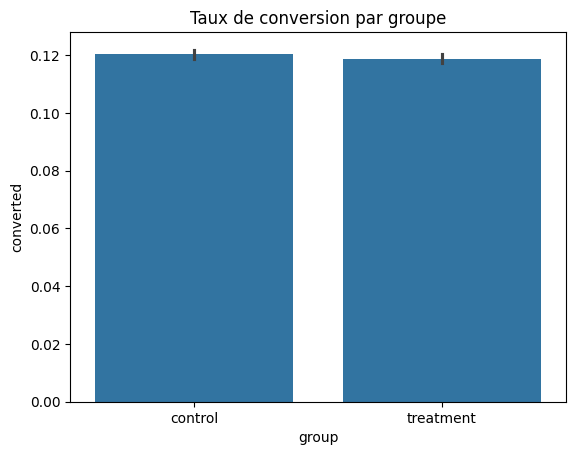

In [35]:


# Taux de conversion par groupe
sns.barplot(x='group', y='converted', data=df)
plt.title("Taux de conversion par groupe")


In [36]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
#df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])


In [37]:
df

,user_id,timestamp,group,landing_page,converted,hour,day_of_week
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,22,Saturday
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,8,Thursday
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,16,Wednesday
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,18,Sunday
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,Saturday
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,22,Tuesday
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,0,Thursday
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,11,Sunday
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,Sunday


In [47]:
# One-hot encoding de day_of_week (on évite le piège des variables dummy)
day_dummies = pd.get_dummies(df['day_of_week'], prefix='day', drop_first=False)

# Concaténer avec le DataFrame original
df = pd.concat([df, day_dummies], axis=1)


In [48]:
df['ab_group'] = df['group'].map({'control': 0, 'treatment': 1})

# Créer une constante pour l'intercept
df['intercept'] = 1

# Définir les variables indépendantes
features = ['ab_group', 'hour'] + list(day_dummies.columns) + ['intercept']
X = df[features].astype(float)

# Modèle logistique
logit_model = sm.Logit(df['converted'], X)
result = logit_model.fit()

# Résumé
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.366098
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290573
Method:                           MLE   Df Model:                            9
Date:                Thu, 22 May 2025   Pseudo R-squ.:               6.638e-05
Time:                        14:43:52   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1180
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ab_group         -0.0149        nan        nan        nan         nan         nan
hour              0.